## Contextualized model

Let's train a model but this time **taking** the context into account

In [9]:
%load_ext autoreload
%autoreload 2

from hatedetection import load_datasets

train_dataset, dev_dataset, test_dataset = load_datasets()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import torch
from transformers import AutoModelForSequenceClassification, AutoTokenizer

model_name = "../models/bert-contextualized-hate-speech-es/"
model = AutoModelForSequenceClassification.from_pretrained(model_name, return_dict=True, num_labels=2)



device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)


model.eval()

tokenizer = AutoTokenizer.from_pretrained(model_name)
tokenizer.model_max_length = 256

In [11]:
def tokenize(batch, context=True, padding='max_length', truncation=True):
    """
    Apply tokenization
    
    Arguments:
    ---------
    
    use_context: boolean (default True)
        Whether to add the context to the 
    """
    
    if context:
        args = [batch['context'], batch['text']]
    else:
        args = [batch['text']]
        
    return tokenizer(*args, padding='max_length', truncation=True)

batch_size = 32
eval_batch_size = 16

my_tokenize = lambda x: tokenize(x, context=True)

train_dataset = train_dataset.map(my_tokenize, batched=True, batch_size=batch_size)
dev_dataset = dev_dataset.map(my_tokenize, batched=True, batch_size=eval_batch_size)
test_dataset = test_dataset.map(my_tokenize, batched=True, batch_size=eval_batch_size)



In [12]:
tokenizer.decode(train_dataset["input_ids"][4])

'[CLS] Les darán DNI provisorio a personas en situación vulnerable, para que puedan empezar a cobrar planes sociales [SEP] usuario Seguimos alimentando vagos [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [P

In [13]:

def format_dataset(dataset):
    dataset = dataset.map(lambda examples: {'labels': examples['HATEFUL']})
    dataset.set_format(type='torch', columns=['input_ids', 'token_type_ids', 'attention_mask', 'labels'])
    return dataset

train_dataset = format_dataset(train_dataset)
dev_dataset = format_dataset(dev_dataset)
test_dataset = format_dataset(test_dataset)

Lo cargamos sólo para evaluar 🤗

In [14]:
from hatedetection.metrics import compute_hate_metrics
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(
    output_dir='./results',
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=eval_batch_size,
)


trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_hate_metrics,
    train_dataset=train_dataset,
    eval_dataset=dev_dataset,
)


In [15]:
import pandas as pd
pd.options.display.max_columns = 40
pd.set_option('display.float_format', lambda x: '%.5f' % x)

df_results = pd.DataFrame([trainer.evaluate(dev_dataset)])

df_results.T

,0
eval_loss,0.59710
eval_accuracy,0.91808
eval_f1,0.83918
eval_precision,0.84400
eval_recall,0.83457
eval_runtime,68.71540
eval_samples_per_second,132.51800
init_mem_cpu_alloc_delta,54684.00000
init_mem_gpu_alloc_delta,0.00000
init_mem_cpu_peaked_delta,18258.00000


## Error Analysis

In [16]:
pred_output = trainer.predict(dev_dataset)

pred_output

PredictionOutput(predictions=array([[ 5.551485 , -5.219334 ],
       [ 5.6552896, -5.28838  ],
       [ 3.9607806, -3.2482803],
       ...,
       [ 5.5436897, -5.185168 ],
       [ 5.5575857, -5.1286983],
       [ 5.64779  , -5.2399983]], dtype=float32), label_ids=array([0, 0, 0, ..., 0, 0, 0]), metrics={'eval_loss': 0.5970990061759949, 'eval_accuracy': 0.9180759938502087, 'eval_f1': 0.8391804121329292, 'eval_precision': 0.8440013387285824, 'eval_recall': 0.834574523878709, 'eval_runtime': 75.2331, 'eval_samples_per_second': 121.037, 'test_mem_cpu_alloc_delta': 212524, 'test_mem_gpu_alloc_delta': 0, 'test_mem_cpu_peaked_delta': 756058, 'test_mem_gpu_peaked_delta': 189042688})

In [24]:
from datasets import ClassLabel
from hatedetection import extended_hate_categories


dev_df = dev_dataset.to_pandas()
dev_df.set_index("id", inplace=True)
PAD_IDX = tokenizer.vocab["[PAD]"]

def decode(example):
    """
    Returns what the BERT models get as input
    """
    input_ids = [x.item() for x in example["input_ids"] if x.item() != PAD_IDX]
    return tokenizer.decode(input_ids)




dev_df["tokenized_text"] = dev_df.apply(decode, axis=1)
dev_df = dev_df[["text", "context", "tokenized_text", "labels"] + extended_hate_categories]

dev_df["predicted"] = pred_output.predictions.argmax(axis=1)

In [25]:
pd.options.display.max_colwidth = 500
dev_df

,text,context,tokenized_text,labels,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL,predicted
id,,,,,,,,,,,,,,
337647,usuario Que cinismo,Wuhan celebra el fin de la cuarentena por el coronavirus con un mensaje para el resto del mundo: “Aprendan de nuestros errores”,[CLS] Wuhan celebra el fin de la cuarentena por el coronavirus con un mensaje para el resto del mundo : [UNK] Aprendan de nuestros errores [UNK] [SEP] usuario Que cinismo [SEP],0,0,0,0,0,0,0,0,0,0,0
336499,"usuario La sociedad les dio la espalda en 2019 y no ayuda mostrarse como una fuerza intentando dar un golpe, Pato.",Patricia Bullrich: “Somos mirados por la sociedad como la posible sustitución de este gobierno en 2021”,"[CLS] Patricia Bullrich : [UNK] Somos mirados por la sociedad como la posible sustitución de este gobierno en 2021 [UNK] [SEP] usuario La sociedad les dio la espalda en 2019 y no ayuda mostrarse como una fuerza intentando dar un golpe, Pato. [SEP]",0,0,0,0,0,0,0,0,0,0,0
387046,"usuario Revolucionario ponerse en bolas? Uy sí, impresionante",¡Calu Rivero se desnudó para Instagram!,"[CLS] ¡ Calu Rivero se desnudó para Instagram! [SEP] usuario Revolucionario ponerse en bolas? Uy sí, impresionante [SEP]",0,0,0,0,0,0,0,0,0,0,0
350341,usuario Como??..si deberia estar en la CARCEL cumpliendo su condena!!..que hace libre????,El líder piquetero Luis D’Elía pidió el indulto presidencial,[CLS] El líder piquetero Luis D [UNK] Elía pidió el indulto presidencial [SEP] usuario Como??.. si deberia estar en la CARCEL cumpliendo su condena!!.. que hace libre???? [SEP],0,0,0,0,0,0,0,0,0,0,0
336008,usuario Seamos serios si en la Pcia de Cornejo y en CABA sus respectivas legislaturas-donde los locales son JxC- sesionan vía remota después no pueden ir en contra de esa via cuando se sesiona en el Congreso Nacional. Las inconsistencias son palmarias,Cristina Kirchner no afloja: le pegó a Horacio Rodríguez Larreta y también a Alfredo Cornejo,[CLS] Cristina Kirchner no afloja : le pegó a Horacio Rodríguez Larreta y también a Alfredo Cornejo [SEP] usuario Seamos serios si en la Pcia de Cornejo y en CABA sus respectivas legislaturas - donde los locales son JxC - sesionan vía remota después no pueden ir en contra de esa via cuando se sesiona en el Congreso Nacional. Las inconsistencias son palmarias [SEP],0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
331427,"usuario Este pibe no puede más de pelotudo!!!! Lleno micros escolares de gente garpando y arriabdolos como ganado y se hace el puritano ahora \nLa gente sabe la clase de porquería que es, no se olvida.","Banderazo 17A. Juan Grabois pidió multas para los manifestantes: ""Hay que aplicar la autoridad""","[CLS] Banderazo 17A. Juan Grabois pidió multas para los manifestantes : "" Hay que aplicar la autoridad "" [SEP] usuario Este pibe no puede más de pelotudo!!!! Lleno micros escolares de gente garpando y arriabdolos como ganado y se hace el puritano ahora La gente sabe la clase de porquería que es, no se olvida. [SEP]",0,0,0,0,0,0,0,0,0,0,0
355482,"usuario No es un mensaje, todo hay que explicarles?",El contundente mensaje de Noelia Marzol sobre el feminismo y el sexo: “Queremos coger en libertad”,"[CLS] El contundente mensaje de Noelia Marzol sobre el feminismo y el sexo : [UNK] Queremos coger en libertad [UNK] [SEP] usuario No es un mensaje, todo hay que explicarles? [SEP]",0,0,0,0,0,0,0,0,0,0,0
400833,"usuario Perón, Perón, que grande sos",Acuerdo con Putin para que Rusia instale una base satelital en el país,"[CLS] Acuerdo con Putin para que Rusia instale una base satelital en el país [SEP] usuario Perón, Perón, que grande sos [SEP]",0,0,0,0,0,0,0,0,0,0,0


<AxesSubplot:ylabel='index'>

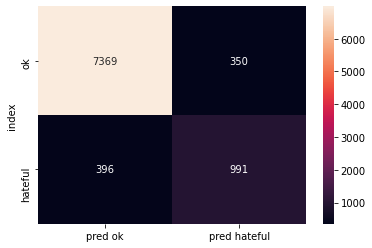

In [43]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = pd.DataFrame(
    confusion_matrix(dev_df["labels"], dev_df["predicted"])
)

cm.columns = ["pred ok", "pred hateful"]

cm["index"] = ["ok", "hateful"]

cm.set_index("index", inplace=True)

normalized = cm
#normalized = (cm - cm.mean(axis=0)) / cm.std(axis=0)
sns.heatmap(normalized, annot=cm, fmt="", robust=True)

## Errors

In [59]:
false_negatives = dev_df.loc[((~dev_df["predicted"]) & (dev_df["labels"])) != 0]

false_positives = dev_df.loc[((dev_df["predicted"]) & (~dev_df["labels"])) != 0]

columns = ["text", "context", "tokenized_text"] + extended_hate_categories
false_negatives = false_negatives[columns]
false_positives = false_positives[columns]

In [73]:
false_negatives.sample(10)

,text,context,tokenized_text,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL
id,,,,,,,,,,,,
389846,"usuario Día 8 de noviembre, día de la marcha de los SOCIOPATAS.",Otro ataque de furia contra un colectivero: una mujer trans le pateó la unidad y le tiró un ladrillazo,"[CLS] Otro ataque de furia contra un colectivero : una mujer trans le pateó la unidad y le tiró un ladrillazo [SEP] usuario Día 8 de noviembre, día de la marcha de los SOCIOPATAS. [SEP]",0,0,1,0,0,0,0,0,0
370074,usuario 🤮🤮🤮🤮🤮🤮,"Florencia Peña: “No debe ser fácil ser hijo mío, pero como mamá estoy a la altura de la circunstancia”","[CLS] Florencia Peña : [UNK] No debe ser fácil ser hijo mío, pero como mamá estoy a la altura de la circunstancia [UNK] [SEP] usuario [UNK] [SEP]",0,1,0,0,0,0,0,0,0
331431,usuario Alto Facho usuario,"Banderazo 17A. Juan Grabois pidió multas para los manifestantes: ""Hay que aplicar la autoridad""","[CLS] Banderazo 17A. Juan Grabois pidió multas para los manifestantes : "" Hay que aplicar la autoridad "" [SEP] usuario Alto Facho usuario [SEP]",0,0,0,0,0,1,0,0,0
357276,"usuario Y a vos qué hay que hacerte? usuario orKo soruyo genocida psicópata asesino de inocentes. usuario 🤡 el odio que le tenes a la gente buena, a la gente de bien 😒🙄",Juan Grabois propuso que se multe a los manifestantes del 17A: “Hay que aplicar la autoridad”,"[CLS] Juan Grabois propuso que se multe a los manifestantes del 17A : [UNK] Hay que aplicar la autoridad [UNK] [SEP] usuario Y a vos qué hay que hacerte? usuario orKo soruyo genocida psicópata asesino de inocentes. usuario [UNK] el odio que le tenes a la gente buena, a la gente de bien [UNK] [SEP]",0,0,0,0,0,1,1,0,0
370128,"usuario "" su corazón es a prueba de balas "" y si, tanta grasa que ni las balas pasan",El infartante desnudo de More Rial,"[CLS] El infartante desnudo de More Rial [SEP] usuario "" su corazón es a prueba de balas "" y si, tanta grasa que ni las balas pasan [SEP]",0,0,0,0,0,0,0,1,0
333885,usuario Más fafafa x favor,"Calu Rivero, desnuda en una playa de Estados Unidos, reflexionó sobre la libertad y el empoderamiento de las mujeres a través del arte","[CLS] Calu Rivero, desnuda en una playa de Estados Unidos, reflexionó sobre la libertad y el empoderamiento de las mujeres a través del arte [SEP] usuario Más fafafa x favor [SEP]",0,0,0,0,0,0,1,0,0
360289,usuario Llamá a Delpo para que te saque la Telaraña!!,El divertido pedido de Jimena Barón a Alberto Fernández por la falta de intimidad en cuarentena,[CLS] El divertido pedido de Jimena Barón a Alberto Fernández por la falta de intimidad en cuarentena [SEP] usuario Llamá a Delpo para que te saque la Telaraña!! [SEP],0,1,0,0,0,0,0,0,0
398778,usuario Vayan a laburar vagos de mierda. Aprendan de Grabois.,El kirchnerismo realizó una caravana a Plaza de Mayo para recordar a Néstor Kirchner,[CLS] El kirchnerismo realizó una caravana a Plaza de Mayo para recordar a Néstor Kirchner [SEP] usuario Vayan a laburar vagos de mierda. Aprendan de Grabois. [SEP],0,0,0,0,1,1,0,0,0
404638,"usuario por que no se ponen a solucionar temas mas urgentes, buscan siempre agradar a los cabezas",Senadores kirchneristas proponen que la mitad de los nuevos billetes de $1.000 tengan la cara de Maradona,"[CLS] Senadores kirchneristas proponen que la mitad de los nuevos billetes de [UNK] 1. 000 tengan la cara de Maradona [SEP] usuario por que no se ponen a solucionar temas mas urgentes, buscan siempre agradar a los cabezas [SEP]",0,0,0,1,1,0,0,0,0


In [76]:
false_positives.sample(10)

,text,context,tokenized_text,CALLS,WOMEN,LGBTI,RACISM,CLASS,POLITICS,DISABLED,APPEARANCE,CRIMINAL
id,,,,,,,,,,,,
370092,usuario Hacer lo que uno quiere se llama LIBERTAD no feminismo...que conceptos equivocados tenés...,"Florencia Peña: “No debe ser fácil ser hijo mío, pero como mamá estoy a la altura de la circunstancia”","[CLS] Florencia Peña : [UNK] No debe ser fácil ser hijo mío, pero como mamá estoy a la altura de la circunstancia [UNK] [SEP] usuario Hacer lo que uno quiere se llama LIBERTAD no feminismo... que conceptos equivocados tenés... [SEP]",0,0,0,0,0,0,0,0,0
404745,"usuario Si el que va a tener al bebé es el que parece hombre, entonces no es trans , es travesti.","Historia: Franco, un hombre trans, tendrá un hijo con Hannah, una mujer trans","[CLS] Historia : Franco, un hombre trans, tendrá un hijo con Hannah, una mujer trans [SEP] usuario Si el que va a tener al bebé es el que parece hombre, entonces no es trans, es travesti. [SEP]",0,0,0,0,0,0,0,0,0
339575,usuario UN CHINO NEGRO !,El extraño cambio en el color de la piel de dos médicos que sobrevivieron al coronavirus en Wuhan,[CLS] El extraño cambio en el color de la piel de dos médicos que sobrevivieron al coronavirus en Wuhan [SEP] usuario UN CHINO NEGRO! [SEP],0,0,0,0,0,0,0,0,0
352492,usuario Que país del orto. Ni robar en paz se puede ahora que lo tirotean a uno.,Un preso que participó del motín en Devoto y fue liberado con la excusa del coronavirus salió a robar y fue herido en un tiroteo con la Policía,[CLS] Un preso que participó del motín en Devoto y fue liberado con la excusa del coronavirus salió a robar y fue herido en un tiroteo con la Policía [SEP] usuario Que país del orto. Ni robar en paz se puede ahora que lo tirotean a uno. [SEP],0,0,0,0,0,0,0,0,0
384426,usuario Aysa es de la Nación... Si quieren estos CHORROS K QUE Aysa sea solo responsabilidad de la Ciudad. Que Cada Provincia haga su planta Potabilizadora y distribución . L9S CHORROS KURCHNERISTAS COMO NO SABEN GESTIONAR Y SOLO SABEN ROBAR DINERO DE LOS IMPUESTOS. KULPAN A LOS DEMAS.,Interna por la Villa 31: AySA apunta al Gobierno de la Ciudad por la falta de agua,[CLS] Interna por la Villa 31 : AySA apunta al Gobierno de la Ciudad por la falta de agua [SEP] usuario Aysa es de la Nación... Si quieren estos CHORROS K QUE Aysa sea solo responsabilidad de la Ciudad. Que Cada Provincia haga su planta Potabilizadora y distribución. L9S CHORROS KURCHNERISTAS COMO NO SABEN GESTIONAR Y SOLO SABEN ROBAR DINERO DE LOS IMPUESTOS. KULPAN A LOS DEMAS. [SEP],0,0,0,0,0,0,0,0,0
402742,usuario SSHH.... HAY MÁS MUGRE ADENTRO Q AFUERA....,“Basurero de la democracia”: cómo quedó Tribunales tras el paso de la marcha por Milagro Sala,[CLS] [UNK] Basurero de la democracia [UNK] : cómo quedó Tribunales tras el paso de la marcha por Milagro Sala [SEP] usuario SSHH.... HAY MÁS MUGRE ADENTRO Q AFUERA.... [SEP],0,0,0,0,0,0,0,0,0
400542,usuario Seguramente la queria poner,Tucumán: masivo respaldo a un joven que fue al acto de graduación en pollera y las autoridades del colegio lo obligaron a cambiarse,[CLS] Tucumán : masivo respaldo a un joven que fue al acto de graduación en pollera y las autoridades del colegio lo obligaron a cambiarse [SEP] usuario Seguramente la queria poner [SEP],0,0,0,0,0,0,0,0,0
388725,usuario Dónalo papu,"Miguel Herrán, Río en La Casa de Papel, y el lado oscuro de su éxito: “El dinero me ha ensuciado como persona”","[CLS] Miguel Herrán, Río en La Casa de Papel, y el lado oscuro de su éxito : [UNK] El dinero me ha ensuciado como persona [UNK] [SEP] usuario Dónalo papu [SEP]",0,0,0,0,0,0,0,0,0
341477,"usuario No son clientes, son prostituyentes!",Coronavirus: el Papa envió ayuda a transexuales que se quedaron sin clientes,"[CLS] Coronavirus : el Papa envió ayuda a transexuales que se quedaron sin clientes [SEP] usuario No son clientes, son prostituyentes! [SEP]",0,0,0,0,0,0,0,0,0


Veamos en qué categorías falla más


In [71]:
hateful = dev_df[dev_df["labels"] == 1]

std = hateful[extended_hate_categories].std()
(false_negatives[extended_hate_categories].mean() - hateful[extended_hate_categories].mean()) / std

CALLS        -0.16003
WOMEN         0.18792
LGBTI         0.07151
RACISM       -0.02460
CLASS         0.07151
POLITICS     -0.01147
DISABLED      0.03928
APPEARANCE   -0.14719
CRIMINAL     -0.17322
dtype: float64

A ver, de lo que vemos:

- Hay sustancialmente más falsos negativos sobre la categoría mujer => veamos ahí!
- Hay muy pocos de apariencia

In [72]:
(false_positives[extended_hate_categories].mean() - hateful[extended_hate_categories].mean()) / std

CALLS        -0.47331
WOMEN        -0.43051
LGBTI        -0.32420
RACISM       -0.66105
CLASS        -0.32420
POLITICS     -0.43754
DISABLED     -0.25542
APPEARANCE   -0.49147
CRIMINAL     -0.46874
dtype: float64

Con **falsos positivos** tenemos:

- 